In [1]:
!pip install pyopencl
import sys 
sys.path.append('/usr/local/lib/python3.6/site-packages')
import pyopencl as cl
import pyopencl.array as cl_array
import numpy as np
import matplotlib.pylab as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 934 kB 34.2 MB/s 
     |████████████████████████████████| 70 kB 9.5 MB/s 
  Created wheel for pytools: filename=pytools-2022.1.12-py2.py3-none-any.whl size=65033 sha256=81e1e824ded3b996666e772a5d4e8c8b5cc4e6ec3787cbb20d681870ebb97e17
  Stored in directory: /root/.cache/pip/wheels/37/5e/9e/76d7430e116b7cab0016fbabb26b896daae1946a3f7dea9915
Successfully built pytools


# Input

In [2]:
N = 20 
k = 50 
T_amb = 25.0
fuentes_de_calor = [[0,0, 50], [5,5, 100]]

# N = 9 
# k = 1
# T_amb = 25.0
# fuentes_de_calor = [[0,0, 50.0],[1,1, 100.0],[2,1, 100.0]]


# Kernel

In [3]:
KernelSource = """
__kernel void UpdateTemp(
  __global float *data_g,
  __global const int *fuentes_de_calor,
  const int N,
  const int k,
  const int cant_fdc,
  const float T_amb
)
  {    
    const int x = get_global_id(0);
    const int y = get_global_id(1);

    float new_temp = 0;

    for (unsigned int i = 0; i < k; i++) {
      new_temp = 0;

      if (x == 0) {
        // Sumamos el vecino izquierdo (borde, con lo cual es temperatura ambiente),
        // y el vecino derecho.
        new_temp += T_amb + data_g[y*N+x+1];
      } else if (x == N-1) {
        // Sumamos el vecino derecho (borde, con lo cual es temperatura ambiente),
        // y el vecino izquierdo.
        new_temp += T_amb + data_g[y*N+x-1];
      } else {
        // No está en el borde, sumamos vecinos izquierdo y derecho.
        new_temp += data_g[y*N+x-1] + data_g[y*N+x+1];
      };

      if (y == 0) {
        // Sumamos el vecino superior (borde, con lo cual es temperatura ambiente),
        // y el vecino inferior.
        new_temp += T_amb + data_g[(y+1)*N+x];
      } else if (y == N-1) {
        // Sumamos el vecino inferior (borde, con lo cual es temperatura ambiente),
        // y el vecino superior.
        new_temp += T_amb + data_g[(y-1)*N+x];
      } else {
        // No está en el borde, sumamos vecinos superior e inferior.
        new_temp += data_g[(y-1)*N+x] + data_g[(y+1)*N+x];
      };

      // Promedio de los vecinos
      new_temp = new_temp/4;

      // Las fuentes de calor no modifican su temperatura
      for(unsigned int i = 0; i < cant_fdc; ++i)
        if(x == fuentes_de_calor[i*3] && y == fuentes_de_calor[i*3+1])
          new_temp = data_g[y*N+x]; 

      barrier(CLK_LOCAL_MEM_FENCE);

      data_g[y*N+x] = new_temp;

      barrier(CLK_LOCAL_MEM_FENCE);
    }
  }
"""

## Sincronismo
Si bien el planteo permite que el Kernel OpenCL itere internamente a lo largo de los pasos k, por la naturaleza del problema necesitamos que haya una coordinación entre los resultados calculados para las distintas posiciones a lo largo de las distintas iteraciones, para lo cual usamos "barriers" en cada iteración. A continuación, se explica en detalle el propósito de cada una:
 

Primer barrier: 
  Supongamos que el work-item a necesita el valor de la matriz calculado por el work-item b. Supongamos también que el work-item b escribe su valor en la matriz antes que el work-item a lo use. Entonces, cuando a lo use, va a terminar usando el nuevo valor de b, cuando en realidad necesitaba el anterior.

Segundo barrier: Supongamos que el work-item a necesita el valor de la matriz calculado por el work-item b. Supongamos también que el work-item a empieza otra iteración antes que el work-item b escriba su valor en la matriz. Entonces, cuando a lo use, va a terminar usando el valor anterior de b, cuando en realidad necesitaba el nuevo.

Con una celda de la entrada independiente, no se puede aportar algo significativo a la salida. Para formar un elemento de la salida, se necesitan analizar varios de la entrada. Por lo tanto, este ejercicio requiere descomposición de datos con respecto a la salida. 

# Inicialización del host

In [4]:
# Obtener la plataforma
plataform_list = cl.get_platforms()

# Obtener los dispositivos
devices = plataform_list[0].get_devices(device_type = cl.device_type.GPU)

# Crear el contexto
context = cl.Context(devices=devices)

# Crear el Command Queue
queue = cl.CommandQueue(
    context,
    properties= cl.command_queue_properties.PROFILING_ENABLE | cl.command_queue_properties.OUT_OF_ORDER_EXEC_MODE_ENABLE
)

# Crear e inicializar el vector de entrada: 
# matriz de tamaño N * N con el valor T_amb en todas sus entradas
T_np = np.full((N, N), T_amb).astype(np.float32)

# Cantidad de fuentes de calor
cant_fdc = len(fuentes_de_calor)

# Agregamos las fuentes de calor a la matriz inicial
for i in range (0, cant_fdc):
  T_np[fuentes_de_calor[i][1], fuentes_de_calor[i][0]] = fuentes_de_calor[i][2]

# NOTE: castear a int hace que el valor de la temperatura de las fuentes de 
# calor se redondee pero no importa porque dentro del kernel no lo usamos
fdc_np = np.reshape(fuentes_de_calor, cant_fdc*3).astype(np.int32)

# Crear e inicializar el vector (bidimensional) de salida
res_np = np.empty_like(T_np)

# Crear e inicializar los Buffers (OpenCL)
data_g = cl.Buffer(context, cl.mem_flags.READ_WRITE | cl.mem_flags.COPY_HOST_PTR, hostbuf = T_np)
fdc_g = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf = fdc_np)

# Crear el programa
program = cl.Program(context, KernelSource).build()

# Crear el kernel
kernel = program.UpdateTemp

# Configurar los argumentos
kernel.set_scalar_arg_dtypes([None, None, np.int32, np.int32, np.int32, np.float32])
kernel.set_args(data_g, fdc_g, N, k, cant_fdc, T_amb)

# Definir el espacio indexado
globalRange = (N, N)
localRange = (N, N)

# Output

Matriz original: 

50.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   
25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   
25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   
25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   
25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   
25.0   25.0   25.0   25.0   25.0   100.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   
25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   2

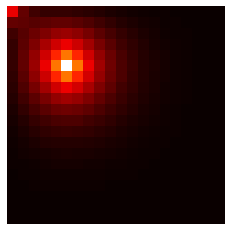

In [5]:
def pretty_print(a):
  for i in range(N):
    for j in range(N):
      print(a[i][j], end = '   ')
    print('')

print('Matriz original: \n')
pretty_print(T_np)
print('\n')

print('Propagando fuentes de calor...\n')

# Ejecutar el kernel
ev = cl.enqueue_nd_range_kernel(queue, kernel, globalRange, localRange)
ev.wait()
elapsed = (ev.profile.end - ev.profile.start)*1e-9
print(f'Tiempo transcurrido en nanosegundos: {elapsed} ns\n')

# Copy result del device al host
copy_ev = cl.enqueue_copy(queue, res_np, data_g, wait_for=[ev])
copy_ev.wait()
elapsed = (copy_ev.profile.end - copy_ev.profile.start)*1e-9
print(f'Tiempo transcurrido en nanosegundos para la copia del device al host: {elapsed} ns\n')

print(f'Matriz final luego de {k} iteraciones: \n')
res_np = res_np.round(2)
pretty_print(res_np)

print('\n')

plt.axis('off')
plt.imshow(res_np, cmap = 'hot', interpolation = 'nearest')
plt.show()

# Para reinicializar el buffer para la próxima vez que se ejecute este bloque
data_g = cl.Buffer(context, cl.mem_flags.READ_WRITE | cl.mem_flags.COPY_HOST_PTR, hostbuf = T_np)
kernel.set_scalar_arg_dtypes([None, None, np.int32, np.int32, np.int32, np.float32])
kernel.set_args(data_g, fdc_g, N, k, cant_fdc, T_amb)